In [1]:
%run setup.ipynb

In [2]:
min_size_roh = 10000

In [3]:
from pathlib import Path

In [4]:
roh_path_main = Path(
    "/kwiat/vector/ag1000g/release/phase2.AR1/roh/main/runs_of_homozygosity.zip")

roh_path_x = Path(
    "/kwiat/vector/ag1000g/release/phase2.AR1/roh/crosses/runs_of_homozygosity.zip")


In [5]:
zz = zarr.ZipStore(roh_path_main)
roh_main = zarr.Group(zz)

In [6]:
zz = zarr.ZipStore(roh_path_x)
roh_x = zarr.Group(zz)

In [7]:
xx = phase2_ar1.df_samples.iloc[0].name

In [8]:
roh_main["2L"][xx].tree()

AA0040-C
 ├── is_marginal (78,) bool
 ├── length (78,) int64
 ├── start (78,) int64
 └── stop (78,) int64

In [9]:
chromosomes

('2R', '2L', '3R', '3L', 'X', 'Y_unplaced', 'UNKN')

In [10]:
autosomes

('2R', '2L', '3R', '3L')

In [11]:
# load cross metadata: parents only
cross_metadata = pd.read_csv(
    Path(phase2_ar1.accessibility_dir) / ".." / "samples/cross.samples.meta.txt",
    index_col=1,
    sep="\t").query("role == 'parent'")

In [12]:
# drop where colony uncertain
cross_metadata = cross_metadata.loc[~cross_metadata.colony_id.str.contains("/")]
#cross_metadata.rename({"colony_id": "population"}, axis=1, inplace=True)

In [13]:
def create_roh_table(samples, contigs, rohhandle, minrohsize=100000):

    mi = pd.MultiIndex.from_product([contigs, samples])
    roh_df = pd.DataFrame(index=mi, columns=["nROH", "sumROH"])
    
    for ix, row in roh_df.iterrows():

        chrom, sample = ix

        # get ROH of each sample/n
        try:
            size = rohhandle[chrom][sample]["length"][:]
            size = np.compress(size >= minrohsize, size)
            roh_df.loc[ix] = len(size), np.sum(size)    
            
        except KeyError:
            print(chrom, sample)
            roh_df.loc[ix] = 0, 0

    roh_summary = roh_df.groupby(level=1).agg(sum)
    totlen = sum([len(phase2_ar1.genome_agamp3[c]) for c in contigs])
    roh_summary["Froh"] = roh_summary.sumROH / totlen
    
    return roh_summary

In [14]:
roh_main["2R"]["AA0040-C"].tree()

AA0040-C
 ├── is_marginal (99,) bool
 ├── length (99,) int64
 ├── start (99,) int64
 └── stop (99,) int64

In [15]:
roh_table_main = create_roh_table(phase2_ar1.df_samples.index, autosomes, roh_main)

In [16]:
roh_table_x = create_roh_table(cross_metadata.index, autosomes, roh_x)

3R AD0278-C


In [17]:
roh_table_x

,nROH,sumROH,Froh
AD0142-C,8,6070250,0.029457
AD0231-C,14,4659256,0.022610
AD0232-C,53,139840957,0.678597
AD0254-C,0,0,0.000000
AD0255-C,58,86351317,0.419032
AD0277-C,165,127094122,0.616742
AD0278-C,1,164061,0.000796
AD0305-C,40,81634612,0.396143
AD0324-C,71,79813832,0.387308
AD0325-C,130,98163602,0.476352


In [18]:
roh_x["3R"]["AD0278-C"].tree()

AD0278-C

In [19]:
roh_x["2L"]["AD0142-C"].tree()

AD0142-C
 ├── is_marginal (47,) bool
 ├── length (47,) int64
 ├── start (47,) int64
 └── stop (47,) int64

In [20]:
# merge with annotations for plotting
annotation = roh_table_main.join(phase2_ar1.df_samples[["population"]])

annotation_x = roh_table_x.join(cross_metadata[["colony_id"]])

In [21]:
mdict = dict(zip(annotation_x.colony_id.unique(), ["D", "s", "^", "v", "P"]))

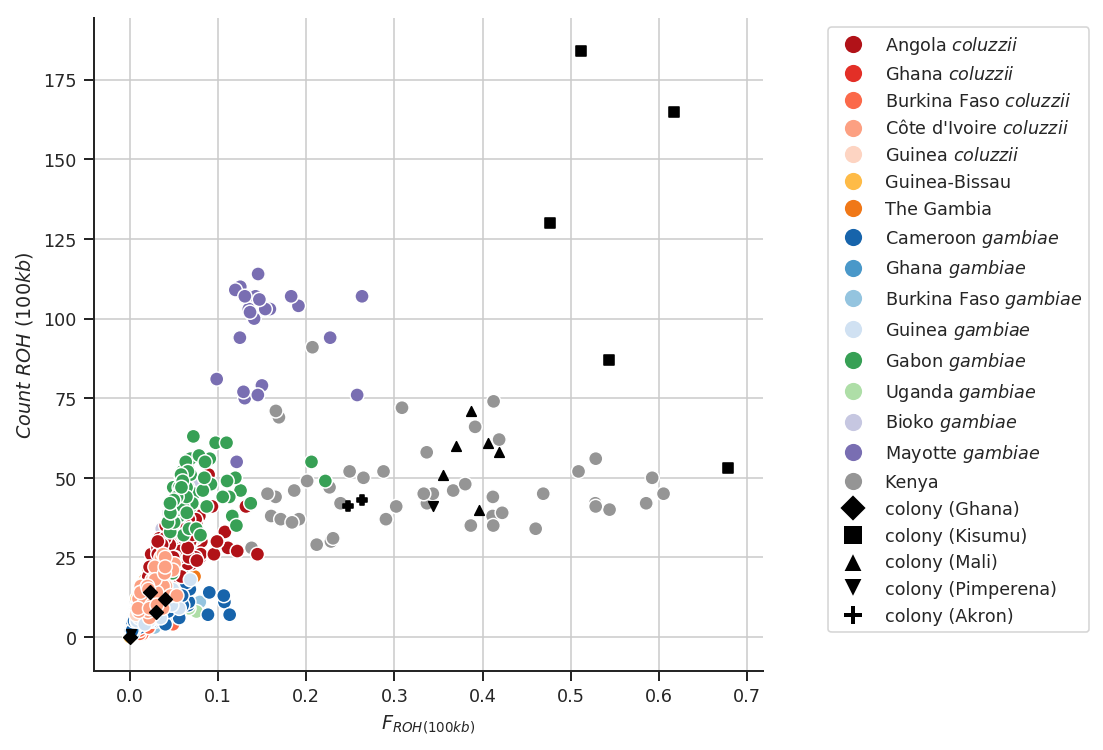

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax)
ax.grid(True)
scatter = sns.scatterplot(
    x="Froh", 
    y="nROH", 
    s=50,
    hue="population", 
    palette=phase2_ar1.pop_colors, 
    data=annotation,legend=False)


for group, df in annotation_x.groupby("colony_id"):
    ax.scatter(df.Froh, df.nROH, c="k", marker=mdict[group])

#Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
handles = [plt.Line2D(
    range(0),
    range(0),
    marker="o",
    color="w",
    markerfacecolor=phase2_ar1.pop_colors[pop], 
    label=phase2_ar1.pop_labels[pop]) for pop in phase2_ar1.pop_ids]

handles += [plt.Line2D(
    range(0),
    range(0),
    marker=mdict[col],
    color="w",
    markerfacecolor="k", 
    label="colony ({0})".format(col)) for col in mdict.keys()]


plt.legend(handles=handles, bbox_to_anchor=(1.5, 1.0), loc=1, markerscale=2)

#_ = ax.legend(loc=5)

_ = ax.set_xlabel(r"$F_{ROH (100kb)}$")
_ = ax.set_ylabel(r"$Count\ ROH\ (100kb)$")

fig.savefig("../artwork/roh.jpeg", dpi=300, bbox_inches="tight")